In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from scipy.stats.distributions import chi2

In [2]:
# Load your time series data into a Pandas DataFrame 
raw_df = pd.read_csv('UoW_load.csv', index_col=0, parse_dates=True)
raw_df.head()

,9:00,10:00,11:00
Dates,,,
2018-01-01,89.4,90.6,88.6
2018-01-02,108.2,104.6,106.0
2018-01-03,110.0,111.6,114.8
2018-01-04,106.4,104.4,109.0
2018-01-05,97.8,100.4,102.4


In [3]:
raw_df.shape # check size of the dataset

(500, 3)

In [4]:
raw_df.dropna(inplace=True) # remove all rows with NULL values from the DataFrame.

In [5]:
raw_df.isnull().sum() # check any null values

9:00     0
10:00    0
11:00    0
dtype: int64

In [6]:
raw_df.shape # check size of the dataset

(500, 3)

In [7]:
raw_df.dtypes # check all the data types are in similer format 

9:00     float64
10:00    float64
11:00    float64
dtype: object

In [8]:
raw_df.describe() # summery of dataset before cleaning

,9:00,10:00,11:00
count,500.00000,500.000000,500.000000
mean,95.34920,99.627600,102.829600
std,20.97215,22.937212,25.271653
min,50.40000,49.200000,48.200000
25%,81.55000,83.000000,84.750000
50%,97.50000,102.800000,105.400000
75%,110.60000,116.050000,120.900000
max,141.20000,148.800000,156.400000


In [9]:
# keep only the 11th hour column for AR model
leven_hour_df = raw_df.copy()
leven_hour_df = leven_hour_df.drop(['9:00', '10:00'], axis=1)
leven_hour_df.head()

,11:00
Dates,
2018-01-01,88.6
2018-01-02,106.0
2018-01-03,114.8
2018-01-04,109.0
2018-01-05,102.4


In [10]:
# get only values as array from pandas data frame
raw_X = leven_hour_df.values
raw_X

array([[ 88.6],
       [106. ],
       [114.8],
       [109. ],
       [102.4],
       [ 87.2],
       [ 67.6],
       [116.2],
       [116. ],
       [114.2],
       [113.4],
       [120.4],
       [ 84.8],
       [ 66.8],
       [121.2],
       [124.6],
       [118.6],
       [133.8],
       [126.8],
       [100.8],
       [ 69.6],
       [138.4],
       [138.4],
       [133.8],
       [142.4],
       [135.6],
       [105.6],
       [ 66.2],
       [135.6],
       [141. ],
       [126.8],
       [123.6],
       [138. ],
       [ 95.8],
       [ 64. ],
       [149.6],
       [152.8],
       [149.6],
       [139.8],
       [135.4],
       [100.2],
       [ 63.2],
       [140.4],
       [146.4],
       [147.8],
       [138.8],
       [128.2],
       [ 96. ],
       [ 67. ],
       [152.6],
       [144.8],
       [145.2],
       [146.8],
       [135.8],
       [104.8],
       [ 71.4],
       [154.4],
       [149.2],
       [144. ],
       [145.8],
       [124.2],
       [104. ],
       [

In [11]:
def plot_df(df, x_label, y_label, title):
    plt.figure(figsize=(12,6))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.plot(df)

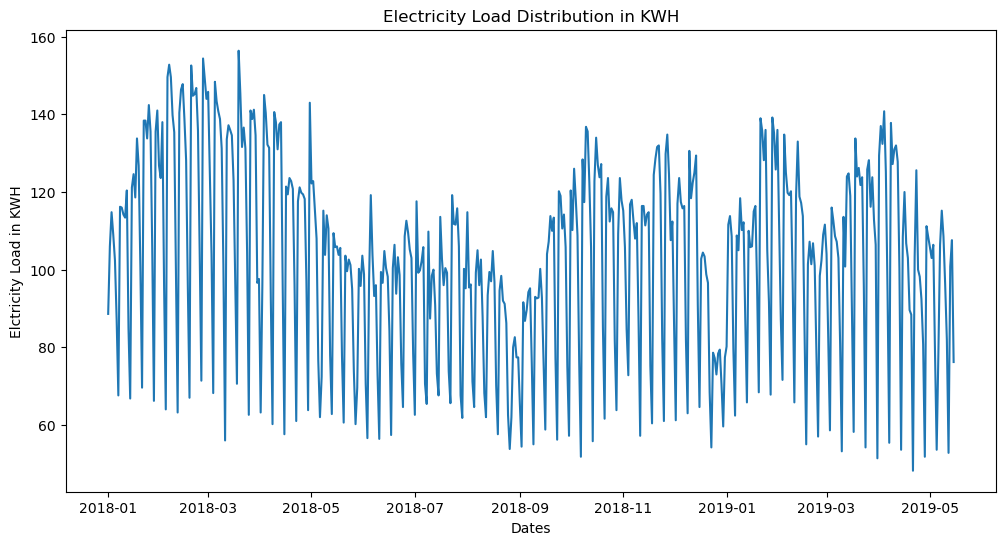

In [12]:
# plot the entire original dataset
plot_df(leven_hour_df, 'Dates', 'Elctricity Load in KWH', 'Electricity Load Distribution in KWH')

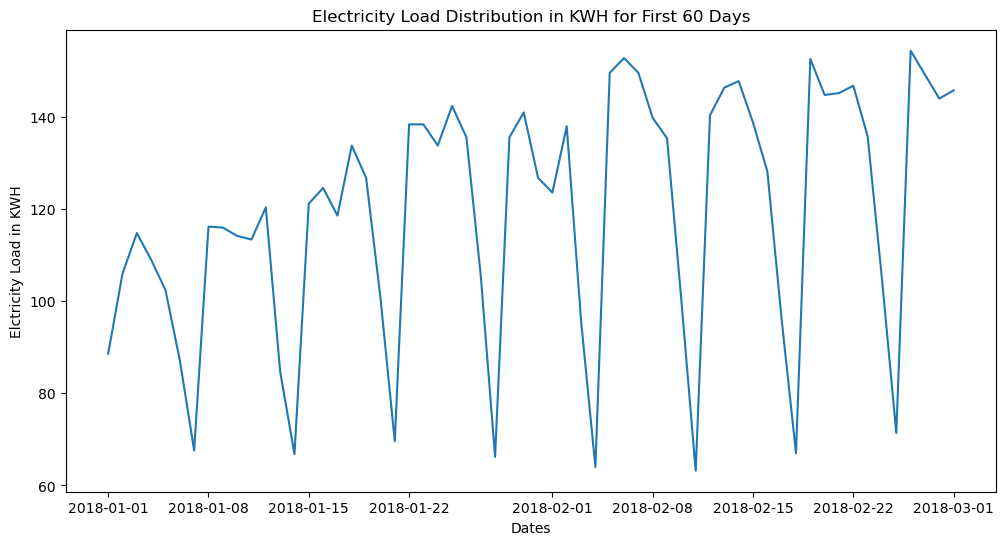

In [13]:
# plot the only 60 records of original dataset
plot_df(leven_hour_df[:60], 'Dates', 'Elctricity Load in KWH', 'Electricity Load Distribution in KWH for First 60 Days')

In [14]:
# Test the dataset to confirm stationarity
# Augmented Dickey-Fuller Test - to check the times series is stationarity ir not
def test_adfulelr(df):
    df_test = adfuller(df, autolag = 'AIC')
    
    print('ADF :', df_test[0]) 
    print('\nP - Value :', df_test[1]) 
    print('\nNo.of Legs :', df_test[2]) 
    print('\nNo.of Observation used for ADF regression and Critical values calculation :', df_test[3]) 
    print('\nCritical values ,\n')
    for key, val in df_test[4].items():
        print('\t', key, ':', val)

In [15]:
test_adfulelr(leven_hour_df['11:00'])

ADF : -2.4121356932542946

P - Value : 0.13834045406163653

No.of Legs : 15

No.of Observation used for ADF regression and Critical values calculation : 484

Critical values ,

	 1% : -3.4439333076538854
	 5% : -2.8675301216074414
	 10% : -2.56996050355167


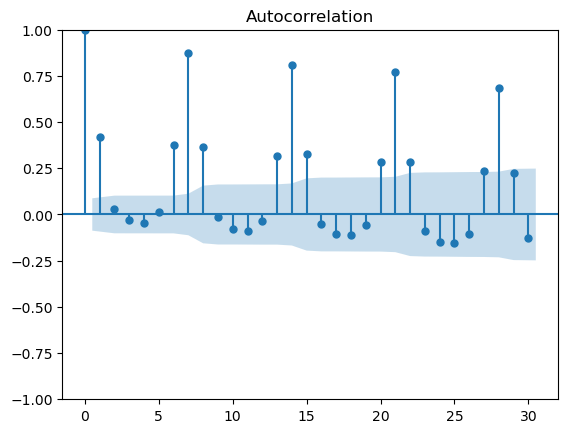

In [16]:
# plot ACF 
acf = plot_acf(leven_hour_df['11:00'], lags=30)

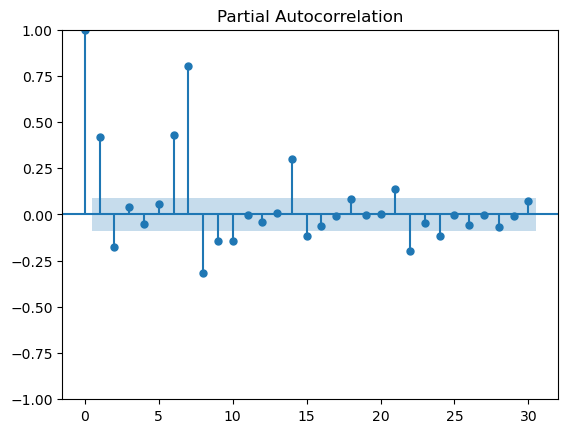

In [17]:
# plot PACF
pacf = plot_pacf(leven_hour_df['11:00'], lags=30, method='ywm')

In [18]:
def split_train_test_sets(df):
    df_val = df.values
    
    train_set = df_val[:len(df_val)-70]
    test_set = df_val[len(df_val)-70:]
    
    print('Train Set Size :', len(train_set))
    print('Test Set Size :', len(test_set))
    
    return train_set, test_set

In [19]:
train_set_org, test_set_org = split_train_test_sets(leven_hour_df['11:00'])

Train Set Size : 430
Test Set Size : 70


In [20]:
print(len(train_set_org) + len(test_set_org))

500


In [21]:
def fit_model(train_set, lag_value, show_summary):
    model = AutoReg(train_set, lags=lag_value)
    model_fitted = model.fit()

    if show_summary:
        print(model_fitted.summary())
    
    return model, model_fitted

In [22]:
def predit_with_test_set(model, train_set, test_set, show_predicted_values):
    
    full_set_length = len(train_set_org) + len(test_set_org)
    
    pred = model.predict(start=len(train_set), end=full_set_length-1, dynamic=False)

    plt.plot(pred,  color='blue')
    plt.plot(test_set, color='red')
    plt.xlabel('No.of Days')
    plt.ylabel('Electricity Load in KWH')
    plt.title('Electricity Load Distribution in KWH for Lags ' + str(len(model.ar_lags)))
    
    if show_predicted_values:
        print(pred)
    
    return pred

In [23]:
def fit_and_predit(train_set, test_set, lag, show_summary=False, show_predicted_values=False):
    model, model_fitted = fit_model(train_set, lag, show_summary)
    predicted_values = predit_with_test_set(model_fitted, train_set, test_set, show_predicted_values)
    
    return model, model_fitted, predicted_values

In [24]:
# Log Likelihood ratio tester
# DF stand for degrees of freedom (defrences of two models)
# If the LLR value is more significant should try for more complicated models
def LLR_test(model_1, model_2, DF=1):
    L1 = model_1.fit().llf
    L2 = model_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

## Using Original Dataset

### AR(1) Model with Original Data

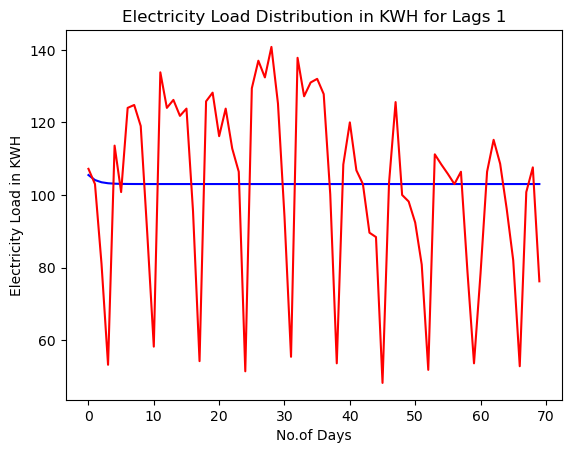

In [25]:
model_org_1, model_fitted_org_1, predicted_values_org_1 = fit_and_predit(train_set_org, test_set_org, 1, False, False)

In [26]:
model_fitted_org_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  430
Model:                     AutoReg(1)   Log Likelihood               -1946.942
Method:               Conditional MLE   S.D. of innovations             22.633
Date:                Tue, 28 Mar 2023   AIC                           3899.883
Time:                        08:19:01   BIC                           3912.068
Sample:                             1   HQIC                          3904.695
                                  430                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.2931      4.584     12.500      0.000      48.309      66.277
y.L1           0.4438      0.043     10.262      0.000       0.359       0.529
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.2532           +0.0000j            2.2532            0.0000
-----------------------------------------------------------------------------
"""

### AR(2) Model with Original Data

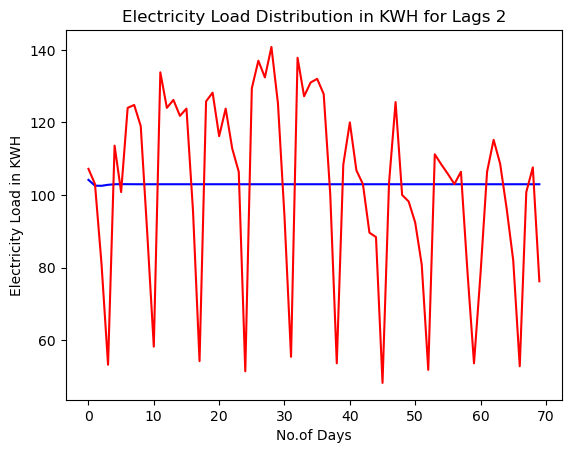

In [27]:
model_org_2, model_fitted_org_2, predicted_values_org_2 = fit_and_predit(train_set_org, test_set_org, 2)

In [28]:
model_fitted_org_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  430
Model:                     AutoReg(2)   Log Likelihood               -1935.577
Method:               Conditional MLE   S.D. of innovations             22.274
Date:                Tue, 28 Mar 2023   AIC                           3879.153
Time:                        08:19:03   BIC                           3895.390
Sample:                             2   HQIC                          3885.566
                                  430                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.6481      5.269     12.839      0.000      57.321      77.975
y.L1           0.5253      0.048     11.054      0.000       0.432       0.618
y.L2          -0.1823      0.048     -3.838      0.000      -0.275      -0.089
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4405           -1.8466j            2.3420           -0.1446
AR.2            1.4405           +1.8466j            2.3420            0.1446
-----------------------------------------------------------------------------
"""

In [29]:
LLR_test(model_org_1, model_org_2)

0.0

### AR(3) Model with Original Data

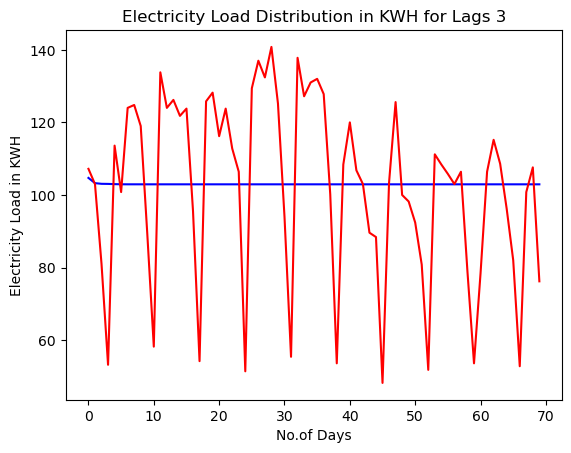

In [30]:
model_org_3, model_fitted_org_3, predicted_values_org_3 = fit_and_predit(train_set_org, test_set_org, 3)

In [31]:
model_fitted_org_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  430
Model:                     AutoReg(3)   Log Likelihood               -1930.702
Method:               Conditional MLE   S.D. of innovations             22.256
Date:                Tue, 28 Mar 2023   AIC                           3871.405
Time:                        08:19:07   BIC                           3891.689
Sample:                             3   HQIC                          3879.417
                                  430                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         63.4911      6.197     10.246      0.000      51.346      75.637
y.L1           0.5360      0.048     11.098      0.000       0.441       0.631
y.L2          -0.2137      0.054     -3.970      0.000      -0.319      -0.108
y.L3           0.0609      0.048      1.260      0.208      -0.034       0.155
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5715           -0.0000j            2.5715           -0.0000
AR.2            0.4702           -2.4839j            2.5280           -0.2202
AR.3            0.4702           +2.4839j            2.5280            0.2202
-----------------------------------------------------------------------------
"""

In [32]:
LLR_test(model_org_2, model_org_3)

0.002

### AR(4) Model with Original Data

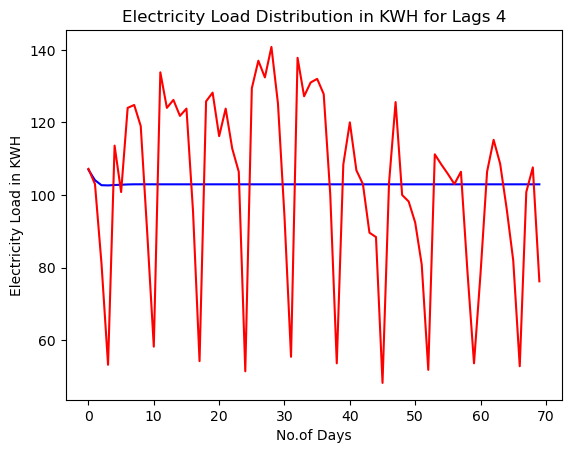

In [33]:
model_org_4, model_fitted_org_4, predicted_values_org_4 = fit_and_predit(train_set_org, test_set_org, 4)

In [34]:
model_fitted_org_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  430
Model:                     AutoReg(4)   Log Likelihood               -1926.246
Method:               Conditional MLE   S.D. of innovations             22.259
Date:                Tue, 28 Mar 2023   AIC                           3864.492
Time:                        08:19:10   BIC                           3888.819
Sample:                             4   HQIC                          3874.102
                                  430                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.3549      6.922      9.586      0.000      52.789      79.921
y.L1           0.5388      0.048     11.131      0.000       0.444       0.634
y.L2          -0.2234      0.055     -4.074      0.000      -0.331      -0.116
y.L3           0.0853      0.055      1.552      0.121      -0.022       0.193
y.L4          -0.0453      0.049     -0.931      0.352      -0.141       0.050
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6951           -2.2124j            2.3190           -0.2984
AR.2           -0.6951           +2.2124j            2.3190            0.2984
AR.3            1.6367           -1.1946j            2.0263           -0.1003
AR.4            1.6367           +1.1946j            2.0263            0.1003
-----------------------------------------------------------------------------
"""

In [35]:
LLR_test(model_org_3, model_org_4)

0.003

### AR(7) Model with Original Data

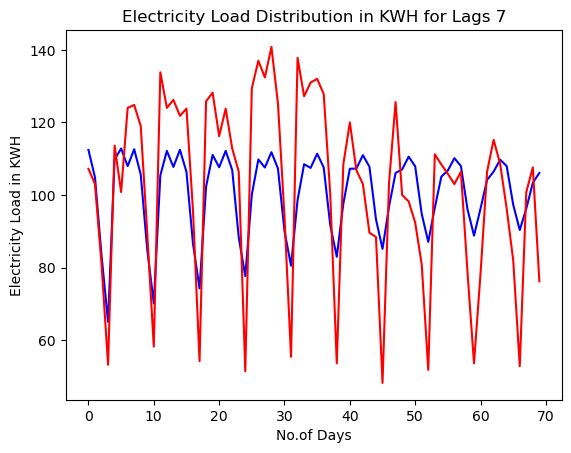

In [36]:
model_org_7, model_fitted_org_7, predicted_values_org_7 = fit_and_predit(train_set_org, test_set_org, 7)

In [37]:
model_fitted_org_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  430
Model:                     AutoReg(7)   Log Likelihood               -1636.818
Method:               Conditional MLE   S.D. of innovations             11.595
Date:                Tue, 28 Mar 2023   AIC                           3291.636
Time:                        08:19:15   BIC                           3328.062
Sample:                             7   HQIC                          3306.029
                                  430                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4829      4.372      1.483      0.138      -2.087      15.053
y.L1           0.1306      0.029      4.568      0.000       0.075       0.187
y.L2          -0.0482      0.029     -1.651      0.099      -0.105       0.009
y.L3           0.0396      0.029      1.352      0.176      -0.018       0.097
y.L4          -0.0243      0.029     -0.823      0.410      -0.082       0.034
y.L5          -0.0229      0.029     -0.779      0.436      -0.081       0.035
y.L6           0.0512      0.029      1.744      0.081      -0.006       0.109
y.L7           0.8114      0.029     28.233      0.000       0.755       0.868
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0102           -0.0000j            1.0102           -0.0000
AR.2            0.6390           -0.7851j            1.0122           -0.1413
AR.3            0.6390           +0.7851j            1.0122            0.1413
AR.4           -0.2239           -1.0005j            1.0253           -0.2850
AR.5           -0.2239           +1.0005j            1.0253            0.2850
AR.6           -0.9517           -0.4764j            1.0643           -0.4261
AR.7           -0.9517           +0.4764j            1.0643            0.4261
-----------------------------------------------------------------------------
"""

In [38]:
LLR_test(model_org_4, model_org_7)

0.0

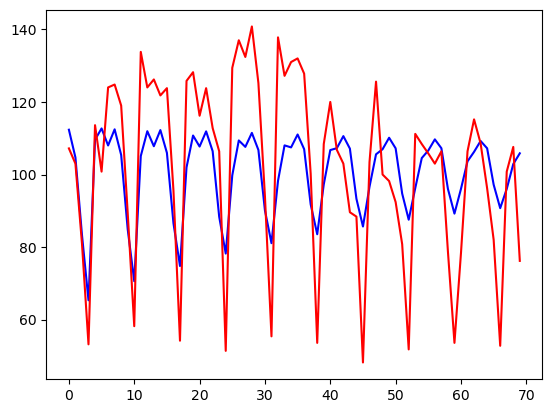

In [39]:
from statsmodels.tsa.arima.model import ARIMA

model_ar_7 = ARIMA(train_set_org, order=(7,0,0)) # order (7,0,0) means simple AR model
results_ar_7 = model_ar_7.fit()
results_ar_7.summary()

pred = results_ar_7.predict(start=len(train_set_org), end=len(raw_X)-1, dynamic=False)

plt.plot(pred,  color='blue')
plt.plot(test_set_org, color='red')

### Forecast 70 days 11th hour load

In [61]:
test_set_org

array([107.2, 103. ,  81. ,  53.2, 113.6, 100.8, 124. , 124.8, 119. ,
        89.4,  58.2, 133.8, 124. , 126.2, 121.8, 123.8,  95.6,  54.2,
       125.8, 128.2, 116.2, 123.8, 112.8, 106.4,  51.4, 129.4, 137. ,
       132.4, 140.8, 125.2,  94. ,  55.4, 137.8, 127.2, 131. , 132. ,
       127.8, 100.2,  53.6, 108.4, 120. , 106.8, 103. ,  89.6,  88.4,
        48.2, 103.4, 125.6, 100. ,  98.2,  92.4,  80.8,  51.8, 111.2,
       108.4, 105.8, 103. , 106.4,  78.8,  53.6,  78.4, 106.4, 115.2,
       108.6,  96.2,  82. ,  52.8, 100.8, 107.6,  76.2])

In [73]:
forecast_set_org_model_7 = model_fitted_7.forecast(70)
forecast_set_org_model_7

array([112.41661938, 104.83662419,  83.37238302,  65.05249275,
       109.79272479, 112.80088394, 107.95825281, 112.59909822,
       105.64099717,  84.8626476 ,  70.14412652, 105.40180257,
       112.1476181 , 107.72013482, 112.45695359, 106.32691365,
        86.53634623,  74.25121518, 102.29741867, 111.05501244,
       107.63280065, 112.1568644 , 106.8721538 ,  88.28480173,
        77.64205901, 100.11208176, 109.77818147, 107.564429  ,
       111.78484979, 107.28358127,  90.0273455 ,  80.50541881,
        98.59042524, 108.46959205, 107.45395973, 111.38288859,
       107.57896798,  91.70822987,  82.97288261,  97.55401253,
       107.2165819 , 107.28015988, 110.96998729, 107.77815805,
        93.29177061,  85.13572737,  96.87698634, 106.06576364,
       107.0429522 , 110.55394514, 107.89925664,  94.75743132,
        87.05725414,  96.46940031, 105.03872645, 106.75241677,
       110.13766518, 107.95738355,  96.09556543,  88.78160366,
        96.26590485, 104.14202742, 106.42252149, 109.72

In [74]:
np.sqrt(mean_squared_error(test_set_org, forecast_set_org_model_7))

18.084863739161904

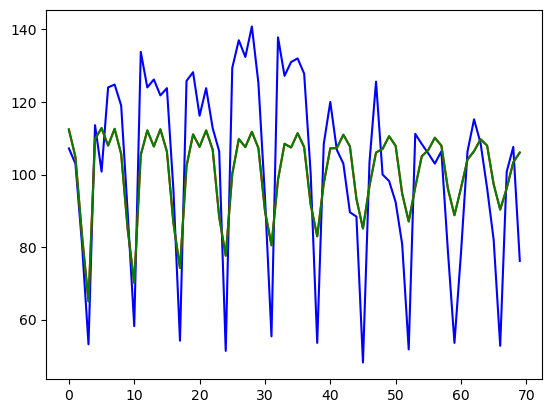

In [70]:
plt.plot(test_set_org,  color='blue')
plt.plot(forecast_set_org_model_7, color='red')
plt.plot(predicted_values_7, color='green')

## Stationarity techniques that i have tried

### Stationarity Using Log

ADF : -2.4933774605461605

P - Value : 0.1170939865641542

No.of Legs : 15

No.of Observation used for ADF regression and Critical values calculation : 484

Critical values ,

	 1% : -3.4439333076538854
	 5% : -2.8675301216074414
	 10% : -2.56996050355167

----------------------After Log----------------------


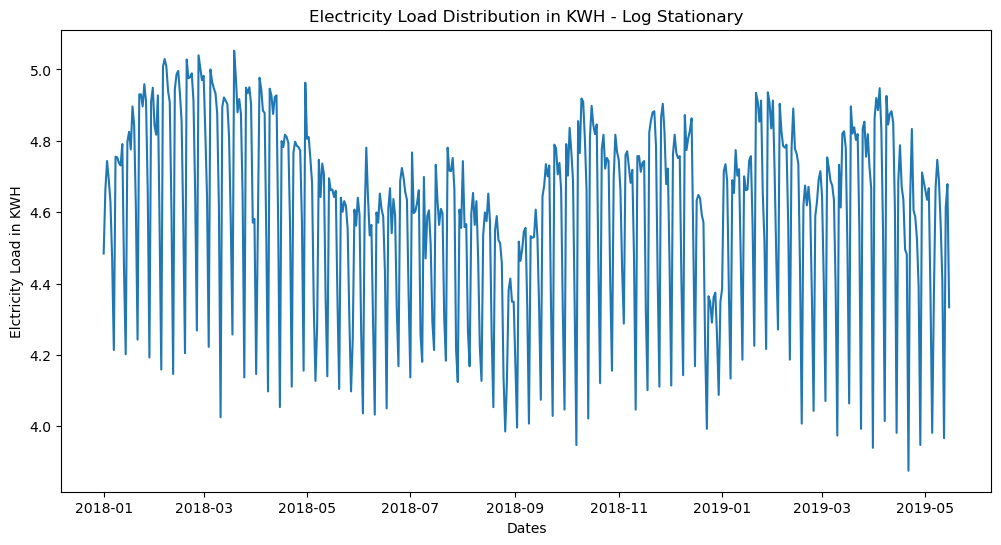

In [62]:
leven_hour_df_logscale = np.log(leven_hour_df['11:00'])

test_adfulelr(leven_hour_df_logscale)

print('\n----------------------After Log----------------------')
plot_df(leven_hour_df_logscale, 'Dates', 'Elctricity Load in KWH', 'Electricity Load Distribution in KWH - Log Stationary')

### Stationarity Using Squre root

ADF : -2.450422235861573

P - Value : 0.12800764966271466

No.of Legs : 15

No.of Observation used for ADF regression and Critical values calculation : 484

Critical values ,

	 1% : -3.4439333076538854
	 5% : -2.8675301216074414
	 10% : -2.56996050355167

----------------------After Squre Root----------------------


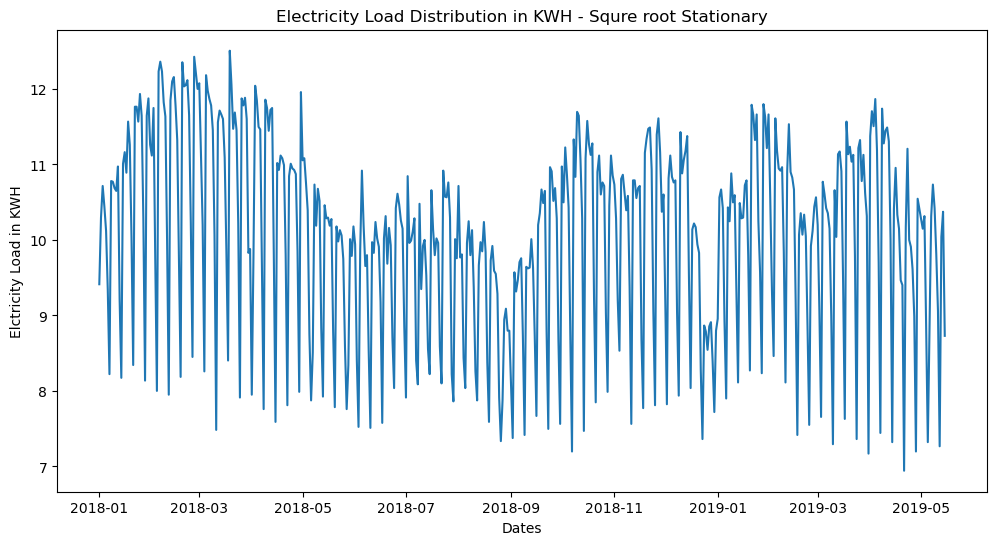

In [63]:
leven_hour_df_sqrt = np.sqrt(leven_hour_df['11:00'])

test_adfulelr(leven_hour_df_sqrt)

print('\n----------------------After Squre Root----------------------')
plot_df(leven_hour_df_sqrt, 'Dates', 'Elctricity Load in KWH', 'Electricity Load Distribution in KWH - Squre root Stationary')

### Stationarity Using Differencing

ADF : -6.816750256203501

P - Value : 2.049928008244648e-09

No.of Legs : 16

No.of Observation used for ADF regression and Critical values calculation : 482

Critical values ,

	 1% : -3.4439899743408136
	 5% : -2.8675550551408353
	 10% : -2.569973792117904

----------------------After Differencing----------------------


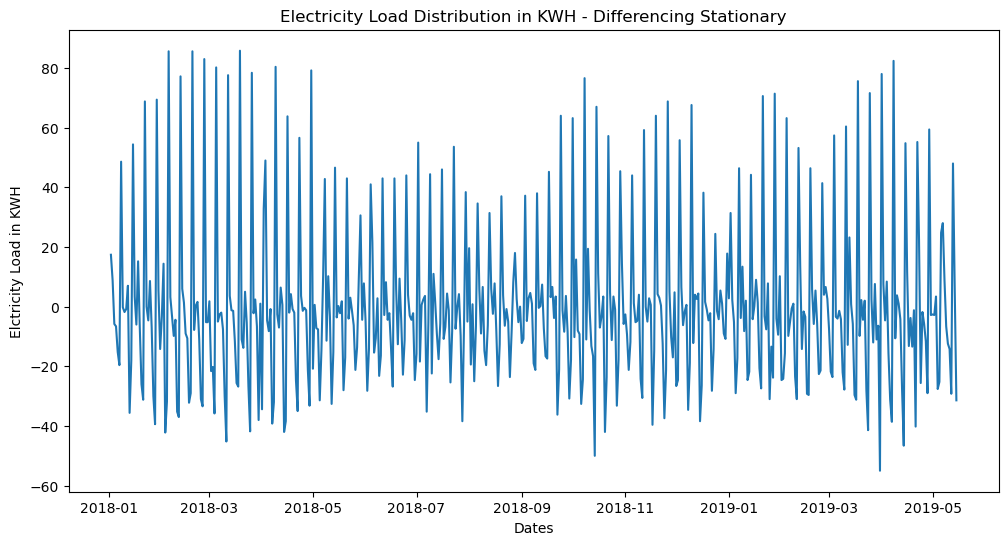

In [64]:
leven_hour_df_diff = leven_hour_df['11:00'] - leven_hour_df['11:00'].shift(1)
leven_hour_df_diff = leven_hour_df_diff.dropna()

test_adfulelr(leven_hour_df_diff)

print('\n----------------------After Differencing----------------------')
plot_df(leven_hour_df_diff, 'Dates', 'Elctricity Load in KWH', 'Electricity Load Distribution in KWH - Differencing Stationary')

### Stationarity Using Seasonal Differencing

ADF : -4.48275668987483

P - Value : 0.000211238965253186

No.of Legs : 18

No.of Observation used for ADF regression and Critical values calculation : 476

Critical values ,

	 1% : -3.444162847239118
	 5% : -2.8676311169658177
	 10% : -2.5700143303792107

----------------------After Seasonal Differencing----------------------


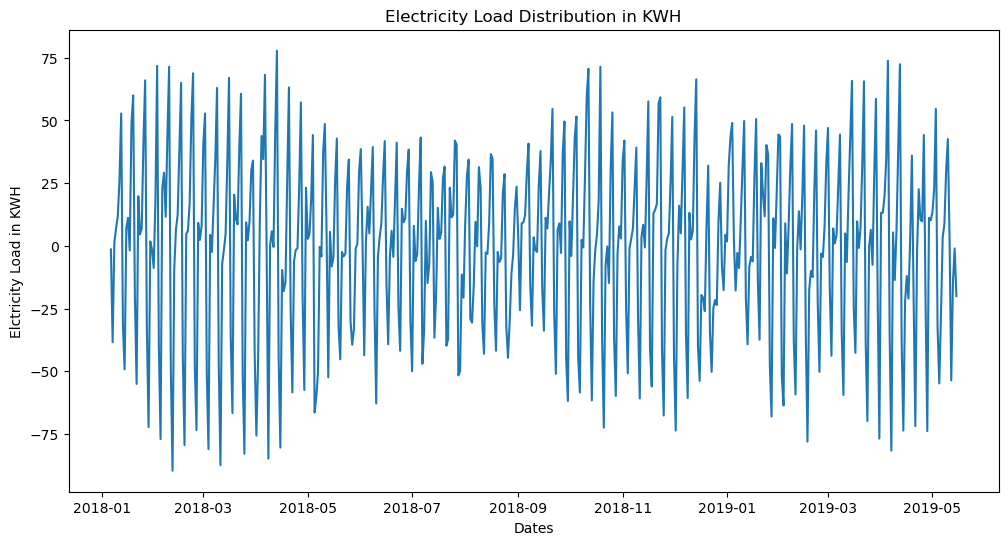

In [60]:
# shift 5 values 
leven_hour_df_seas_diff = leven_hour_df['11:00'] - leven_hour_df['11:00'].shift(5)

# remove NaN values
leven_hour_df_seas_diff = leven_hour_df_seas_diff.dropna()

test_adfulelr(leven_hour_df_seas_diff)

print('\n----------------------After Seasonal Differencing----------------------')
plot_df(leven_hour_df_seas_diff, 'Dates', 'Elctricity Load in KWH', 'Electricity Load Distribution in KWH')

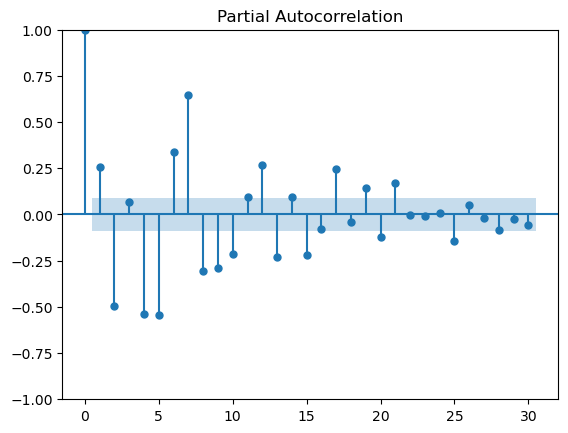

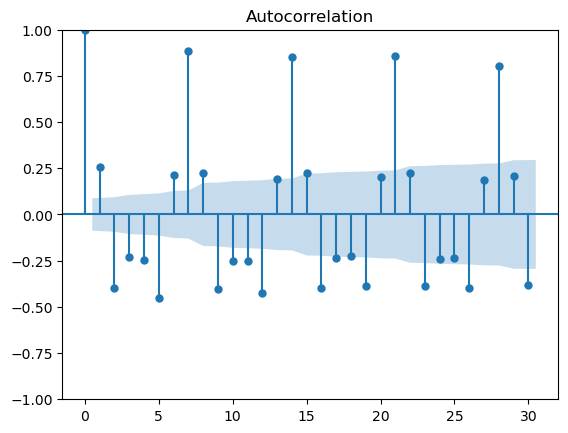

In [53]:
pacf_seas_diff = plot_pacf(leven_hour_df_seas_diff, lags=30, method='ywm')
acf_seas_diff = plot_acf(leven_hour_df_seas_diff, lags=30)

In [54]:
train_set_st, test_set_st = split_train_test_sets(leven_hour_df_seas_diff)

Train Set Size : 425
Test Set Size : 70


## Using Stationary Dataset (Stationarized using Seasonal Differencing)

### AR(1) Model with Stationary Data

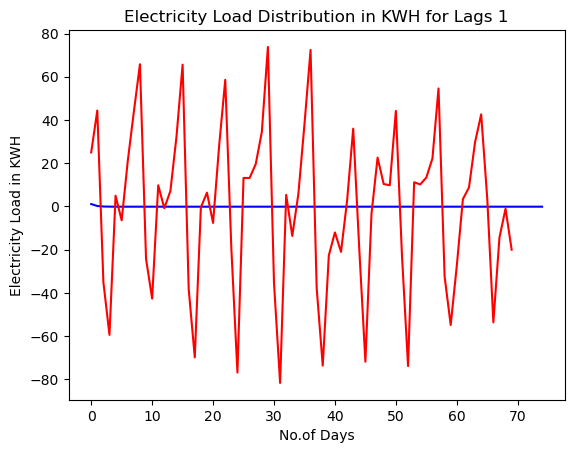

In [65]:
model_st_1, model_fitted_st_1, predicted_values_st_1 = fit_and_predit(train_set_st, test_set_st, 1)

In [66]:
model_fitted_st_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  425
Model:                     AutoReg(1)   Log Likelihood               -2097.061
Method:               Conditional MLE   S.D. of innovations             34.020
Date:                Tue, 28 Mar 2023   AIC                           4200.122
Time:                        19:24:56   BIC                           4212.271
Sample:                             1   HQIC                          4204.922
                                  425                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0684      1.652     -0.041      0.967      -3.307       3.170
y.L1           0.2611      0.047      5.570      0.000       0.169       0.353
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.8294           +0.0000j            3.8294            0.0000
-----------------------------------------------------------------------------
"""

### AR(2) Model with Stationary Data

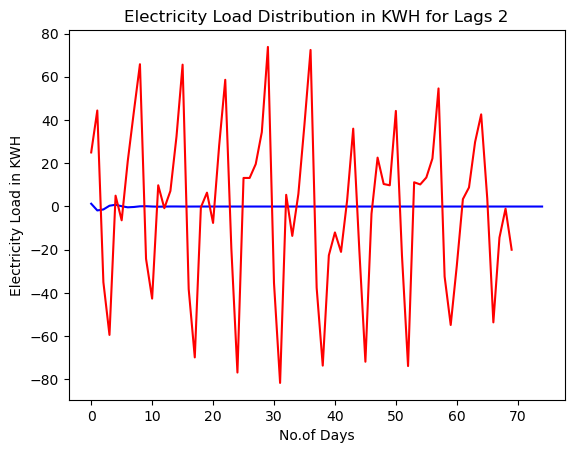

In [67]:
model_st_2, model_fitted_st_2, predicted_values_st_2 = fit_and_predit(train_set_st, test_set_st, 2)

In [68]:
model_fitted_st_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  425
Model:                     AutoReg(2)   Log Likelihood               -2030.934
Method:               Conditional MLE   S.D. of innovations             29.439
Date:                Tue, 28 Mar 2023   AIC                           4069.867
Time:                        19:25:52   BIC                           4086.057
Sample:                             2   HQIC                          4076.264
                                  425                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0217      1.431     -0.015      0.988      -2.827       2.784
y.L1           0.3916      0.042      9.319      0.000       0.309       0.474
y.L2          -0.5000      0.042    -11.898      0.000      -0.582      -0.418
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.3916           -1.3589j            1.4142           -0.2053
AR.2            0.3916           +1.3589j            1.4142            0.2053
-----------------------------------------------------------------------------
"""

### AR(3) Model with Stationary Data

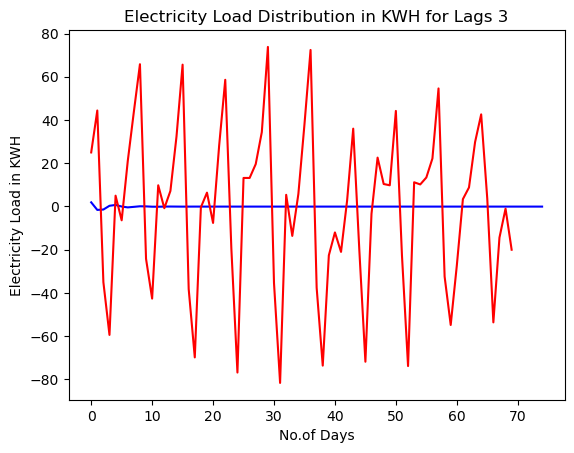

In [69]:
model_st_3, model_fitted_st_3, predicted_values_st_3 = fit_and_predit(train_set_st, test_set_st, 3)

In [70]:
model_fitted_st_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  425
Model:                     AutoReg(3)   Log Likelihood               -2025.312
Method:               Conditional MLE   S.D. of innovations             29.382
Date:                Tue, 28 Mar 2023   AIC                           4060.624
Time:                        19:26:21   BIC                           4080.849
Sample:                             3   HQIC                          4068.616
                                  425                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0519      1.430     -0.036      0.971      -2.855       2.751
y.L1           0.4302      0.049      8.864      0.000       0.335       0.525
y.L2          -0.5295      0.046    -11.498      0.000      -0.620      -0.439
y.L3           0.0744      0.048      1.536      0.125      -0.021       0.169
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.2847           -1.4042j            1.4328           -0.2182
AR.2            0.2847           +1.4042j            1.4328            0.2182
AR.3            6.5450           -0.0000j            6.5450           -0.0000
-----------------------------------------------------------------------------
"""

### AR(4) Model with Stationary Data

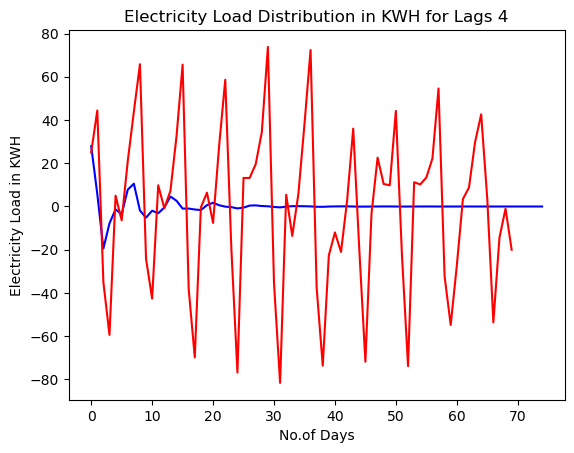

In [71]:
model_st_4, model_fitted_st_4, predicted_values_st_4 = fit_and_predit(train_set_st, test_set_st, 4)

In [72]:
model_fitted_st_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  425
Model:                     AutoReg(4)   Log Likelihood               -1942.910
Method:               Conditional MLE   S.D. of innovations             24.436
Date:                Tue, 28 Mar 2023   AIC                           3897.820
Time:                        19:27:08   BIC                           3922.076
Sample:                             4   HQIC                          3907.406
                                  425                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0088      1.191     -0.007      0.994      -2.343       2.325
y.L1           0.4729      0.040     11.679      0.000       0.394       0.552
y.L2          -0.8268      0.044    -18.790      0.000      -0.913      -0.741
y.L3           0.3148      0.044      7.165      0.000       0.229       0.401
y.L4          -0.5570      0.041    -13.741      0.000      -0.636      -0.478
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.7062           -0.8952j            1.1402           -0.1437
AR.2            0.7062           +0.8952j            1.1402            0.1437
AR.3           -0.4236           -1.0961j            1.1752           -0.3087
AR.4           -0.4236           +1.0961j            1.1752            0.3087
-----------------------------------------------------------------------------
"""

### AR(7) Model with Stationary Data

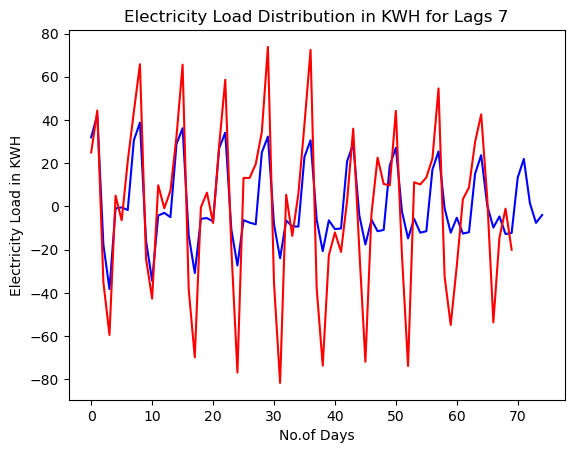

In [73]:
model_st_7, model_fitted_st_7, predicted_values_st_7 = fit_and_predit(train_set_st, test_set_st, 7)

In [74]:
model_fitted_st_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  425
Model:                     AutoReg(7)   Log Likelihood               -1714.703
Method:               Conditional MLE   S.D. of innovations             14.632
Date:                Tue, 28 Mar 2023   AIC                           3447.405
Time:                        19:27:50   BIC                           3483.725
Sample:                             7   HQIC                          3461.763
                                  425                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0846      0.716     -0.118      0.906      -1.487       1.318
y.L1           0.1324      0.037      3.554      0.000       0.059       0.205
y.L2          -0.1606      0.037     -4.309      0.000      -0.234      -0.088
y.L3          -0.0406      0.036     -1.122      0.262      -0.111       0.030
y.L4          -0.0106      0.036     -0.293      0.770      -0.082       0.060
y.L5          -0.2462      0.036     -6.820      0.000      -0.317      -0.175
y.L6           0.1277      0.037      3.421      0.001       0.055       0.201
y.L7           0.6461      0.037     17.337      0.000       0.573       0.719
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1042           -0.0000j            1.1042           -0.0000
AR.2            0.6396           -0.7809j            1.0094           -0.1408
AR.3            0.6396           +0.7809j            1.0094            0.1408
AR.4           -0.2288           -0.9865j            1.0127           -0.2863
AR.5           -0.2288           +0.9865j            1.0127            0.2863
AR.6           -1.0617           -0.4633j            1.1583           -0.4345
AR.7           -1.0617           +0.4633j            1.1583            0.4345
-----------------------------------------------------------------------------
"""

C:\Users\sadde\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


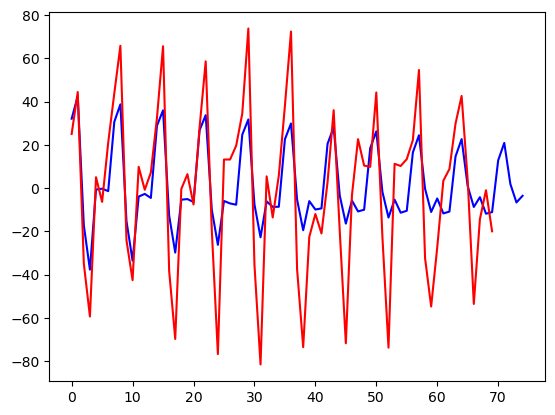

In [28]:
model_ar_st_7 = ARIMA(train_set_st, order=(7,0,0)) # order (1,0,0) means simple AR model
results_ar_st_7 = model_ar_st_7.fit()
results_ar_st_7.summary()

pred_st_arima = results_ar_st_7.predict(start=len(train_set_st), end=len(raw_X)-1, dynamic=False)

plt.plot(pred_st_arima,  color='blue')
plt.plot(test_set_st, color='red')